In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import random
from google.colab.patches import cv2_imshow

In [2]:
# from google.colab import drive
# drive.mount("/content/drive/",force_remount=True)

In [3]:
data_dir= "/content/drive/My Drive/TF3 C3 W1 Data/"

In [4]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except:
  tpu = None
  gpu = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print("Running on TPUS",tpu.cluster_spec().as_dict()["worker"])
elif len(gpu)>1:
    tf.distribute.MirroredStrategy([x.name for x in gpu])
    print("Running on gpus",[x.name for x in gpu])
elif len(gpu) == 1:
  strategy = tf.distribute.get_strategy()
  print("Running on one gpu",gpu[0].name)
else:
  strategy = tf.distribute.get_strategy()
  print("Running on CPU")

print("Running on accelarator",strategy.num_replicas_in_sync)


Running on one gpu /device:GPU:0
Running on accelarator 1


In [5]:
def display_bounding_box(image,x1,y1,x2,y2,color=(0,255,0),thickness=3): 
  image = np.array(image)     #converting to numpy seems usefull
  cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),color,thickness)
  cv2_imshow(image)

In [6]:
def display_bb_with_all_values(images,bbox,color=(0,255,0),thicknes=3,pic_number=10):
  image = images[pic_number].numpy()
  bbox = bbox[pic_number]
  shape = image.shape
  factor_x = tf.cast(shape[1],dtype=tf.float32)
  factor_y = tf.cast(shape[0],dtype=tf.float32)
  a,b,c,d = bbox
  display_bounding_box(image,a,b,c,d,color,thicknes)

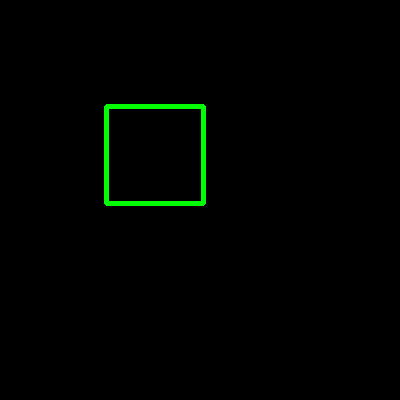

In [7]:
display_bounding_box(np.random.rand(400,400,3),203,203,106,106)

In [8]:
def plot_metrics(metric_name,title):
  plt.title(title)
  plt.plot(history.history[metric_name],label=metric_name)
  plt.plot(history.history["val_"+metric_name],label="val_"+metric_name)
  plt.legend()
  plt.show()

In [9]:
# value are stored in 
# the form of 
# ymin
# xmin
# ymax
# xmax
# so to order to make a rectangle we have to shift some values which is done in bbox_list
# and the values are stored in normalized form 
# so we are multiplying it with the shape of corresponding side
def read_image_tfds(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [10]:
#creating dataset and making it into a list and a bounding boc list
def dataset_to_numpy(dataset):
  if tf.executing_eagerly():
    ds_images,ds_bboxs =[],[]
    for image,bbox in dataset:
      ds_images.append(image)
      ds_bboxs.append(bbox)
  return (np.array(ds_images)),(np.array(ds_bboxs)) 

In [11]:
def train_dataset():
  dataset,info = tfds.load("caltech_birds2010",with_info=True,split="train",data_dir=data_dir,try_gcs=True)
  train_data = dataset.map(read_image_tfds,num_parallel_calls=16)
  return train_data
def test_dataset():
  dataset = tfds.load("caltech_birds2010",split="test",data_dir=data_dir,try_gcs=True)
  test_data = dataset.map(read_image_tfds,num_parallel_calls=16)
  return test_data

In [12]:
train_data = train_dataset()
test_data = test_dataset()

In [13]:
train_images,train_bbox = dataset_to_numpy(train_data)
test_images,test_bbox = dataset_to_numpy(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [14]:
test_images.shape[0],train_images.shape[0]

(3033, 3000)

In [15]:
train_bbox[0].shape

(4,)

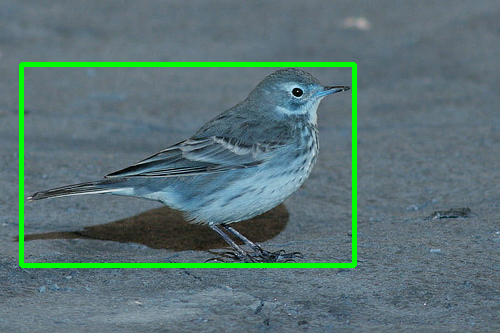

In [16]:
display_bb_with_all_values(np.array(train_images),np.array(train_bbox),pic_number=999)

In [17]:
def read_image_tfds_with_bounding_boxes(images,boxes):
  image = tf.cast(images,dtype=tf.float32)
  shape = tf.shape(image)
  factor_x = tf.cast(shape[1],dtype=tf.float32)
  factor_y = tf.cast(shape[0],dtype=tf.float32)

  image = tf.image.resize(image,(224,224,))
  image = image/255.0

  bbox_list = [boxes[0] / factor_x , 
                 boxes[1] / factor_y, 
                 boxes[2] / factor_x , 
                 boxes[3] / factor_y]

  return image,bbox_list

In [18]:
#droping remainder just to smooth out the curve of validation loss coz they will effect the the rate of converging the loss.

In [19]:
def making_training_dataset(dataset):
  dataset = dataset.map(read_image_tfds_with_bounding_boxes,num_parallel_calls=16)
  dataset = dataset.shuffle(512,reshuffle_each_iteration=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
  dataset = dataset.prefetch(-1)
  return dataset

def making_validation_dataset(dataset):
  dataset = dataset.map(read_image_tfds_with_bounding_boxes,num_parallel_calls=16)
  dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
  return dataset

In [20]:
BATCH_SIZE= 64 * strategy.num_replicas_in_sync
with strategy.scope():
  training_data = making_training_dataset(train_data)
  testing_data = making_validation_dataset(test_data)

In [21]:
training_data,testing_data

(<PrefetchDataset shapes: ((64, 224, 224, 3), (64, 4)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((64, 224, 224, 3), (64, 4)), types: (tf.float32, tf.float32)>)

In [22]:
def feature_extraction_layer(inputs):
  mobnet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                             weights="imagenet",
                                             include_top=False)
  mobnet_layer = mobnet(inputs)
  return mobnet_layer

def mid_layers(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024,activation="relu")(x)
  x = tf.keras.layers.Dense(512,activation="relu")(x)
  return x

def bounding_box_layer(inputs):
  x = tf.keras.layers.Dense(4)(inputs)
  return x

In [23]:
def final_model(inputs):
  x = feature_extraction_layer(inputs)
  x = mid_layers(x)
  x = bounding_box_layer(x)

  model = tf.keras.Model(inputs=inputs,outputs=x)

  return model

In [24]:
def overall_model():

  inputs = tf.keras.layers.Input(shape=(224,224,3))

  model = final_model(inputs)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer = tf.keras.optimizers.SGD(momentum=0.9),
                metrics="mse")
  
  return model

In [25]:
with strategy.scope():
  model = overall_model()

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052  

In [27]:
#Cloud tpus can only access gcs file,as only gcs system is registered.
#sp we have to ditch data_dir and download it from gcs
#have to ditch tpus
#file ["local"] issue

In [28]:

steps_per_epoch=train_images.shape[0] // BATCH_SIZE
validation_step = train_images.shape[0] // BATCH_SIZE
print(steps_per_epoch,validation_step)

46 46


In [29]:
epochs = 20
steps_per_epoch=train_images.shape[0] // BATCH_SIZE
validation_step = 1
history = model.fit(training_data,validation_data=testing_data,epochs=epochs,steps_per_epoch=steps_per_epoch,validation_steps=validation_step)

Epoch 1/20
46/46 [==============================] - 30s 449ms/step - loss: 0.1479 - mse: 0.1479 - val_loss: 0.2773 - val_mse: 0.2773
Epoch 2/20
46/46 [==============================] - 20s 425ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.1790 - val_mse: 0.1790
Epoch 3/20
46/46 [==============================] - 20s 430ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.1560 - val_mse: 0.1560
Epoch 4/20
46/46 [==============================] - 20s 431ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.1391 - val_mse: 0.1391
Epoch 5/20
46/46 [==============================] - 20s 439ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.1113 - val_mse: 0.1113
Epoch 6/20
46/46 [==============================] - 20s 433ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.1017 - val_mse: 0.1017
Epoch 7/20
46/46 [==============================] - 20s 434ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 8/20
46/46 [==============================] - 20s 439ms/step - 

In [30]:
#zig zag in validation data is due to the uneven steps per epochs

In [31]:
#tf.keras.backend.clear_session()

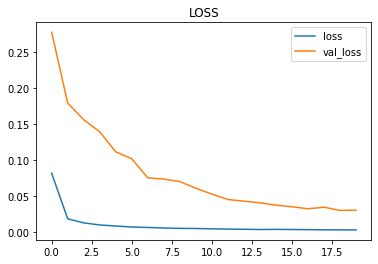

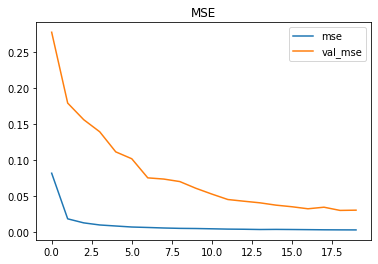

In [32]:
plot_metrics("loss","LOSS")
plot_metrics("mse","MSE")

In [33]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds_with_bounding_boxes(image, bbox)
    
    return original_image, image, bbox_list

In [34]:
def dataset_to_numpy_with_original_bboxes_util(dataset):

    normalized_dataset = dataset.map(read_image_with_shape)
    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

In [35]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(test_data)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Number of predictions where iou > threshold(0.5): 984
Number of predictions where iou < threshold(0.5): 2049


In [36]:
type(normalized_images)

numpy.ndarray

In [74]:
pred = model.predict(normalized_images[20].reshape(1,224,224,3))

In [75]:
# normalized_images[3]

In [76]:
pred

array([[0.21966681, 0.35005847, 0.7145062 , 1.0284101 ]], dtype=float32)

In [77]:
pred[0,0]

0.21966681

In [78]:
shape = original_images[20].shape
start_points = (int(pred[0,0]*shape[1]),int(pred[0,1]*shape[0]))
end_points = (int(pred[0,2]*shape[1]),int(pred[0,3]*shape[0]))

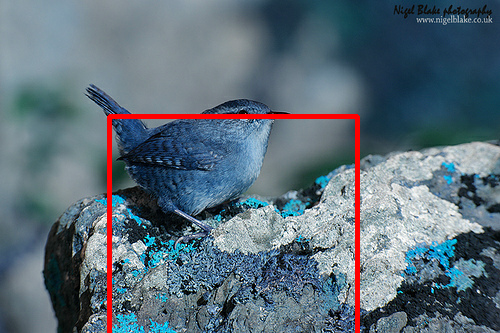

In [79]:
image = cv2.rectangle(original_images[20],start_points,end_points,(0,0,255),3)
cv2_imshow(image)
